# Lab 6

In [1]:
## init libs
import numpy as np
import cv2 as cv
from math import pi
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, gca, imshow, plot, show, subplot
from numpy.fft import fft2, fftshift
from numpy.fft import ifft2, ifftshift
from multiprocessing.pool import ThreadPool #多线程线程池，加速计算
%matplotlib inline

## Fitting Techniques
### Least Squares(LS)
For linear model $y=kx+b$, our goal is to find suitable $k$ and $b$, let MSE be minimized
$$
minimize \Sigma^n_{i=1}(y_i-(mx_i+b))^2
$$
The solution will be
$$
m= \frac{n\Sigma(x_i y_i)-\Sigma x_i \Sigma y_i}{n \Sigma(x_i^2)-(\Sigma x_i)^2}
$$
$$
b=\frac{\Sigma y_i -m \Sigma x_i}{n}
$$

### Total Least Squares
完全最小二乘更适合x，y都存在误差的情况

For linear model $y=kx+b$, our goal is to find suitable $k$ and $b$, let the perpendicular distance between point and fitting line to be minimized
$$
minimize \Sigma^n_{i=1}\frac{(mx_i+b-y_i)^2}{1+m^2}
$$
The solution solved by SVD. Suppose matrix $A=[x,y]$
$$
A=U\Sigma V^T
$$
The fitting coefficients are determined by $V$

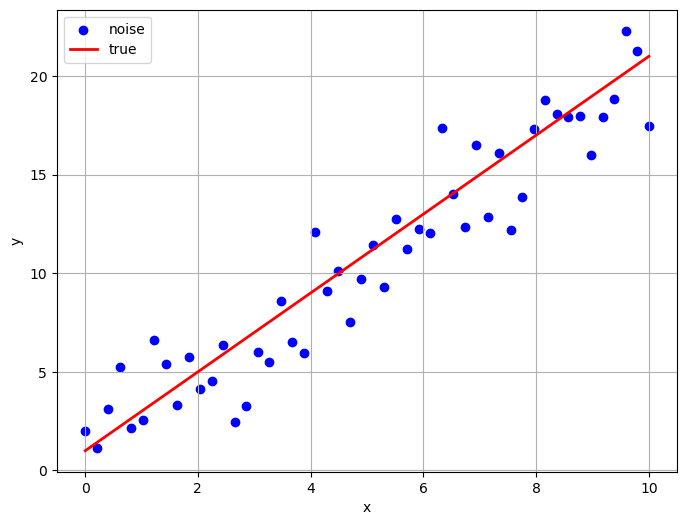

In [2]:
## prepare noise data

# set seed a contant to make the data reuse
np.random.seed(42)
n_points=50
k=2.0 # k:y=kx+b
b=1.0 # b:y=kx+b
noise_std=2.0

x = np.linspace(0, 10, n_points)
y_true = k * x + b

noise = np.random.normal(0, noise_std, n_points)
y_noise = y_true + noise

plt.figure(figsize=(8, 6))
plt.scatter(x, y_noise, color='blue', label='noise')
plt.plot(x, y_true, color='red', label='true', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# LS
n = len(x)
k_ls = (n * np.sum(x * y_noise) - np.sum(x) * np.sum(y_noise)) / (n * np.sum(x**2) - (np.sum(x))**2)
b_ls = (np.sum(y_noise) - k_ls * np.sum(x)) / n

print(f"拟合直线方程: y = {k_ls:.2f}x + {b_ls:.2f}")

拟合直线方程: y = 1.88x + 1.13


[[-0.4308926  -0.90240322]
 [ 0.90240322 -0.4308926 ]]
TLS: y = 2.09x + 0.08


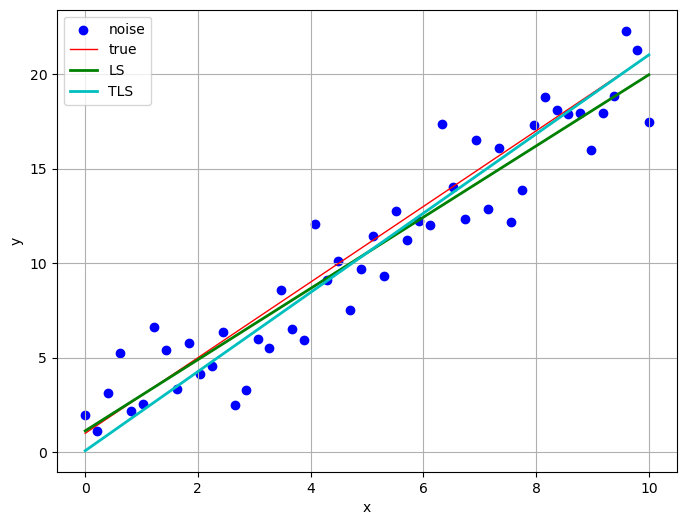

In [4]:
# TLS

A = np.vstack([x, y_noise]).T
#print(A)
# 构造一个二维矩阵 A，每行是一个数据点 (x[i], y_noise[i])

# SVD
U, s, Vt = np.linalg.svd(A)
print(Vt) # U是左奇异矩阵，Vt是右奇异矩阵，s是奇异值

# Extract the coefficient of the fitting line
a,b = Vt[-1, :]  # 从最后一行提取出直线的系数，这样子是ax+by+c=0
x_mean = np.mean(x)
y_mean = np.mean(y_noise)
c=-a*x_mean-b*y_mean
k_tls = -a /b
b_tls = -c / b

print(f"TLS: y = {k_tls:.2f}x + {b_tls:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(x, y_noise, color='blue', label='noise')
plt.plot(x, y_true, color='red', label='true', linewidth=1)
plt.plot(x, k_ls*x+b_ls, color='green', label='LS', linewidth=2)
plt.plot(x, k_tls*x+b_tls, color='c', label='TLS', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## Random Sample Consensus(RANSAC)
RANSAC is a model estimation technique used to process data containing large amounts of noise. It finds the model parameters that best fit the data through random sampling and iteration.There are steps as follow:
- Random sampling: sample a small set from the data, for example, two points is enough for fitting line
- Calculate models' parameters
- Judge inlier data by threshold
- Choose suitable model by quantity of inlier data
- Iteration above steps
- Model optimization: use inlier data to fitting new model

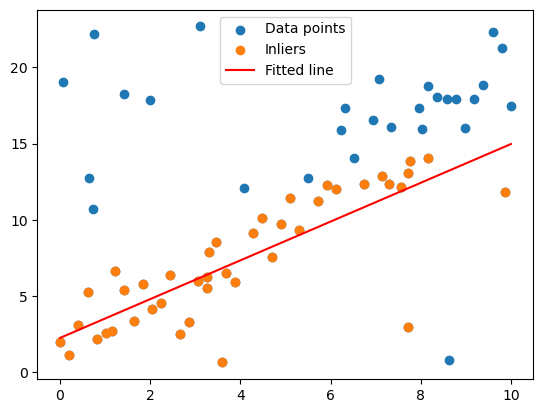

In [5]:
def ransac_line_fitting(points, n_iterations, threshold):
    best_model = None
    best_inliers = []
    
    for _ in range(n_iterations):
        # Random sampling
        sample_indices = np.random.choice(len(points), 2, replace=False)
        sample_points = points[sample_indices]
        
        # Calculate models' parameters
        x1, y1 = sample_points[0]
        x2, y2 = sample_points[1]
        kr = (y2 - y1) / (x2 - x1)
        br = y1 - kr * x1
        
        # Judge inlier data
        distances = np.abs(a * points[:, 0] - points[:, 1] + b) / np.sqrt(a**2 + 1)
        inliers = points[distances < threshold]
        
        # Choose suitable model
        if len(inliers) > len(best_inliers):
            best_model = (kr, br)
            best_inliers = inliers
    
    # Model optimization
    if len(best_inliers) > 1:
        x = best_inliers[:, 0]
        y = best_inliers[:, 1]
        kr, br = np.polyfit(x, y, 1)
        best_model = (kr, br)
    
    return best_model, best_inliers

np.random.seed(42)
n_points=50
k=2.0 # k:y=kx+b
b=1.0 # b:y=kx+b

x = np.linspace(0, 10, n_points)
y_true = k * x + b + np.random.normal(0, 2, n_points)
points = np.column_stack((x, y_true))

# add noise
n_outliers = 20
outliers_x = np.random.uniform(0, 10, n_outliers)
outliers_y = np.random.uniform(0, 25, n_outliers)
points = np.vstack((points, np.column_stack((outliers_x, outliers_y))))

# RANSAC parameter
n_iterations = 100
threshold = 5.0

best_model, best_inliers = ransac_line_fitting(points, n_iterations, threshold)

# show
plt.scatter(points[:, 0], points[:, 1], label="Data points")
plt.scatter(best_inliers[:, 0], best_inliers[:, 1], label="Inliers")
if best_model is not None:
    a, b = best_model
    x_line = np.linspace(0, 10, 100)
    y_line = a * x_line + b
    plt.plot(x_line, y_line, color='red', label="Fitted line")
plt.legend()
plt.show()

## Image Alignment
### Detect feature points in both images
Here we use sift to detect
- Build Gauss pyramid 高斯模糊
- Build DoG pyramid 通过相邻尺度的高斯模糊图像相减：在同一八度内，取相邻两层高斯模糊图像相减，生成 DoG 图像
- Find features with direction and scale in DoG 在 DoG 图像中，比较每个像素与其周围 26 个邻域点（当前层 8 个 + 上下层各 9 个，如果这个点是局部极值，那么标记为候选特征点
- The simplified version has no optimizations

sift是经典视觉算法，在图像中找到具有尺度不变性和旋转不变性的关键点（特征点）

### Find corresponding pairs
There are many algorithms to match the key points, like KNN

### Use these pairs to align images

In [6]:
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d

import numpy as np
from scipy.ndimage import gaussian_filter, sobel
import cv2
# 简化的SIFT（Scale-Invariant Feature Transform，尺度不变特征变换） 算法
def compute_gradient(image):
    """
    计算图像的梯度幅值和方向
    """
    dx = sobel(image, axis=1, mode='constant')  # 水平梯度
    dy = sobel(image, axis=0, mode='constant')  # 垂直梯度
    magnitude = np.sqrt(dx ** 2 + dy ** 2)  # 梯度幅值
    orientation = np.arctan2(dy, dx) * (180 / np.pi)  # 梯度方向（角度）
    orientation[orientation < 0] += 360  # 将方向转换为 [0, 360) 范围
    return magnitude, orientation
# 梯度更大，人感受越清晰，就是特征
def compute_orientation_histogram(magnitude, orientation, center, size, num_bins=36):
    # 用于计算某个关键点周围区域的梯度方向直方图
    """
    计算关键点周围区域的梯度方向直方图
    """
    hist = np.zeros(num_bins)
    bin_width = 360 / num_bins #计算每个方向区间的宽度（单位：度）。
    radius = int(round(size * 1.5))  # 关键点周围区域半径
    x, y = int(round(center[0])), int(round(center[1]))

    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if (x + i >= 0 and x + i < magnitude.shape[1] and
                y + j >= 0 and y + j < magnitude.shape[0]): #检查当前点是否在图像边界内
                dist = np.sqrt(i ** 2 + j ** 2)
                if dist <= radius:
                    bin_idx = int(np.floor(orientation[y + j, x + i] / bin_width)) #计算当前像素点的梯度方向所属的直方图区间。
                    hist[bin_idx % num_bins] += magnitude[y + j, x + i] * np.exp(-0.5 * (dist / (0.5 * size)) ** 2) #计算当前像素点的梯度幅值，并乘以一个高斯权重。

    return  hist #hist 是一个长度为 36 的数组，每个元素表示一个方向区间（0-10°, 10-20°, ...）的累加幅值

def build_gaussian_pyramid(image, num_octaves, num_scales, sigma):
    #
    pyramid = []
    k = 2 ** (1 / num_scales)
    for octave in range(num_octaves):
        octave_images = []
        for scale in range(num_scales + 3):  # +3 for DoG ：额外加 3 层是为了后续构建 DoG（高斯差分）金字塔，确保有足够的层来计算差分
            if octave == 0 and scale == 0: #第一八度的第一层直接使用原始图像
                octave_images.append(image)
            elif scale == 0:
                # down sampling
                octave_images.append(cv2.resize(pyramid[octave - 1][-3], # pyramid[octave - 1][-3]：取上一八度的倒数第三层
                                            (0, 0), fx=0.5, fy=0.5, 
                                            interpolation=cv2.INTER_NEAREST))
            else:
                # blur
                sigma_total = sigma * (k ** scale) #同一八度内的后续层通过高斯模糊生成
                octave_images.append(gaussian_filter(octave_images[scale - 1], sigma_total))
        pyramid.append(octave_images)
    return pyramid

def build_dog_pyramid(gaussian_pyramid):
    # 
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = []
        for i in range(1, len(octave)):
            dog_octave.append(octave[i] - octave[i - 1])
        dog_pyramid.append(dog_octave)
    return dog_pyramid

def find_keypoints(dog_pyramid, threshold=0.01):
    #
    keypoints = []
    for octave_idx, octave in enumerate(dog_pyramid):
        for scale_idx in range(1, len(octave) - 1):
            magnitude, orientation = compute_gradient(octave[scale_idx])
            for i in range(1, octave[scale_idx].shape[0] - 1):
                for j in range(1, octave[scale_idx].shape[1] - 1):
                    #  3x3x3 
                    patch = np.stack([
                        octave[scale_idx - 1][i - 1:i + 2, j - 1:j + 2],
                        octave[scale_idx][i - 1:i + 2, j - 1:j + 2],
                        octave[scale_idx + 1][i - 1:i + 2, j - 1:j + 2]
                    ]) # 提取当前像素在当前层及上下层的 3×3×3 邻域
                    center = patch[1, 1, 1]
                    if abs(center) > threshold and (
                        (center == patch.max()) or (center == patch.min())
                    ):
                        
                        x = j * (2 ** octave_idx)
                        y = i * (2 ** octave_idx)
                        size = 1.6 * (2 ** octave_idx)
                        response = center  
                        
                        hist = compute_orientation_histogram(magnitude, orientation, (j, i), size)
                        angle = np.argmax(hist) * (360 / len(hist))  # 确定关键点的主方向

                        keypoints.append((x, y, size, angle, response))
    return keypoints

image = cv.imread('rock1.jpg')
image = cv.cvtColor(image,cv.COLOR_RGB2GRAY)
image = image.astype(np.float32) / 255.0

num_octaves = 4
num_scales = 3
sigma = 1.6

gaussian_pyramid = build_gaussian_pyramid(image, num_octaves, num_scales, sigma)
dog_pyramid = build_dog_pyramid(gaussian_pyramid)
keypoints = find_keypoints(dog_pyramid)
  
print(f"Detected {len(keypoints)} keypoints")

output_image = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_GRAY2BGR)
for kp in keypoints:
    x, y, size, angle, response = kp
    cv.circle(output_image, (x, y), 2, (0, 255, 0), -1)
    # angle
    dx = size * np.cos(np.deg2rad(angle))
    dy = size * np.sin(np.deg2rad(angle))
    cv.line(output_image, (int(x), int(y)), (int(x + dx), int(y + dy)), (0, 0, 255), 1)

figure(figsize=(6, 8))
imshow(output_image)
show()

ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

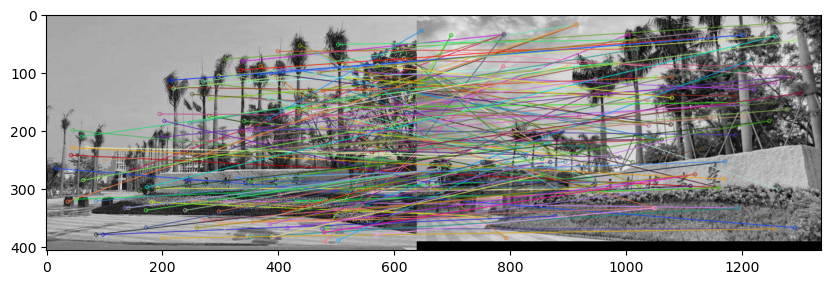

In [ ]:
num_octaves = 4
num_scales = 3
sigma = 1.6

img1 = cv.imread('rock1.jpg')
img1 = cv.cvtColor(img1,cv.COLOR_RGB2GRAY)
img1g = img1.astype(np.float32) / 255.0

gaussian_pyramid = build_gaussian_pyramid(img1g, num_octaves, num_scales, sigma)
dog_pyramid = build_dog_pyramid(gaussian_pyramid)
kp1 = find_keypoints(dog_pyramid)

img2 = cv.imread('rock2.png')
img2 = cv.cvtColor(img2,cv.COLOR_RGB2GRAY)
img2g = img2.astype(np.float32) / 255.0

gaussian_pyramid = build_gaussian_pyramid(img2g, num_octaves, num_scales, sigma)
dog_pyramid = build_dog_pyramid(gaussian_pyramid)
kp2 = find_keypoints(dog_pyramid)
arr1= np.array([row[-3:] for row in kp1], dtype=np.float32)
arr2= np.array([row[-3:] for row in kp2], dtype=np.float32)
# print(arr1)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(arr1, arr2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# tuple-->cv2.KeyPoint
cvkps1 = []
for row in kp1:
    x, y, size, angle, response = row
    keypoint = cv.KeyPoint(
        x=x, y=y, size=size, angle=angle, response=response,
        octave=0, class_id=-1
    )
    cvkps1.append(keypoint)
    
cvkps2 = []
for row in kp2:
    x, y, size, angle, response = row
    keypoint = cv.KeyPoint(
        x=x, y=y, size=size, angle=angle, response=response,
        octave=0, class_id=-1
    )
    cvkps2.append(keypoint)

matched_image = cv2.drawMatches(
    img1, cvkps1, img2, cvkps2, good_matches, None,
    None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)     
figure(figsize=(10, 20))
imshow(matched_image)
show()

## Gabor Filter
Before run this file, you must install some packages in your conda env 

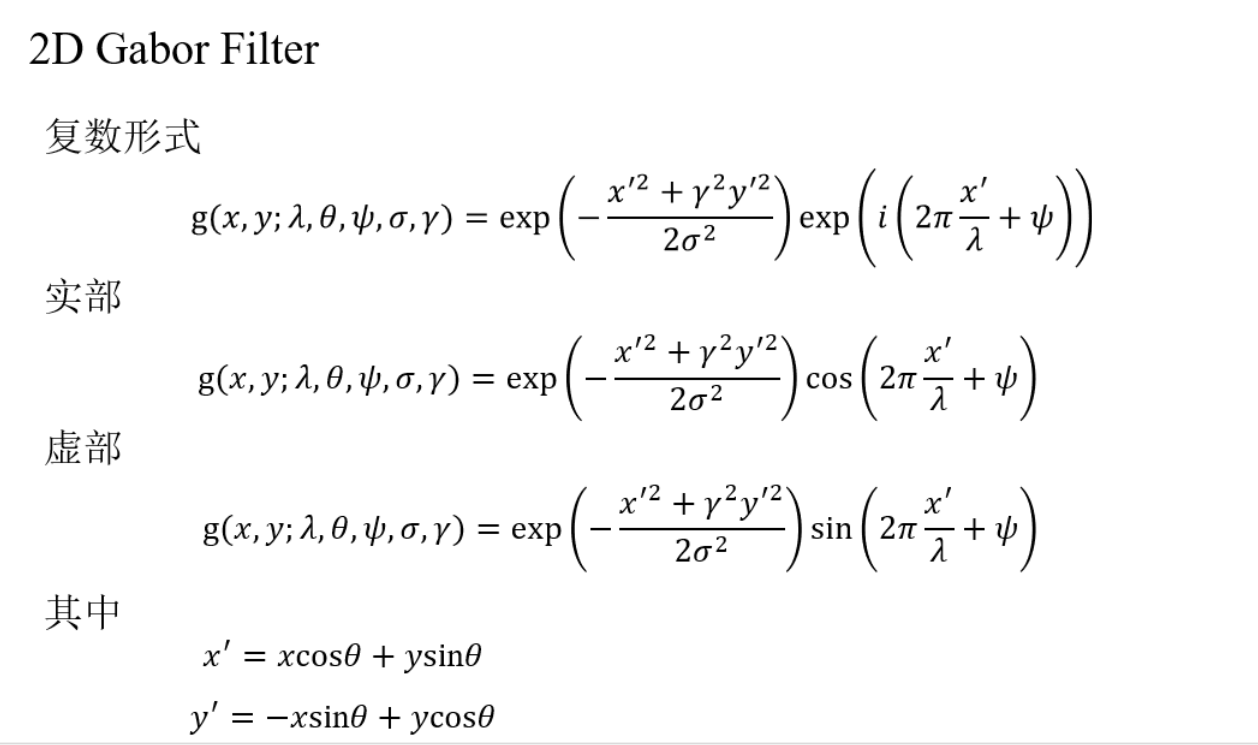

In [ ]:
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, Theta=0):
    # 在空间域和频率域都有局部特性，既能捕捉空间位置信息，又能分析频率信息
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = Theta / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor

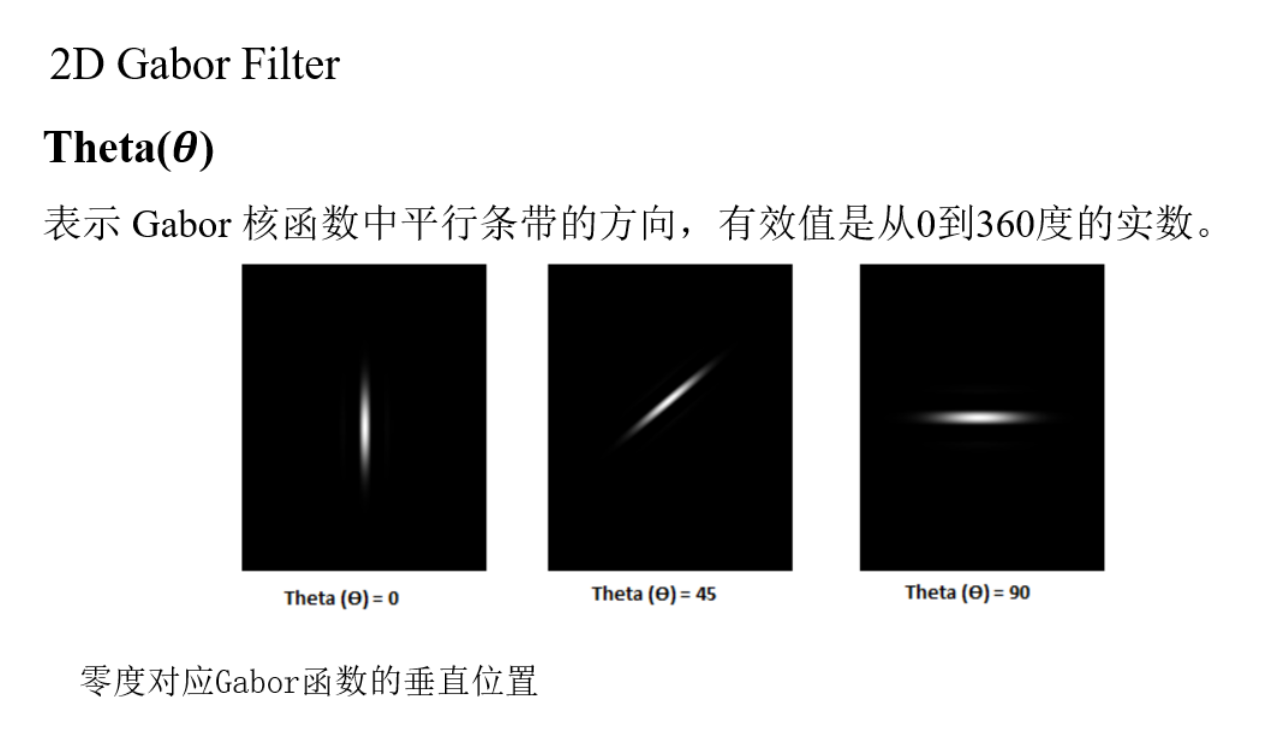

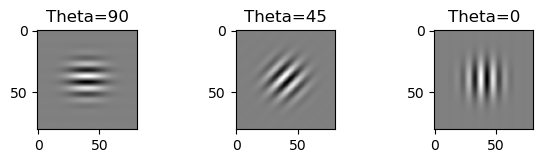

In [ ]:
# show the gabor filter-Theta

gabor_img = Gabor_filter(K_size=81, Sigma=10., Theta=90., Lambda=10, Psi=pi/2, Gamma=1.)

gabor_img_90 = Gabor_filter(K_size=81, Sigma=10., Theta=90., Lambda=10, Psi=pi/2, Gamma=1.)

gabor_img_45 = Gabor_filter(K_size=81, Sigma=10., Theta=45., Lambda=10, Psi=pi/2, Gamma=1.)

gabor_img_0 = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=10, Psi=pi/2, Gamma=1.)


plt.subplot(131),plt.imshow(gabor_img_90, cmap="gray"),plt.title("Theta=90")

plt.subplot(132),plt.imshow(gabor_img_45, cmap="gray"),plt.title("Theta=45")

plt.subplot(133),plt.imshow(gabor_img_0, cmap="gray"),plt.title("Theta=0")

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=1, hspace=1)


plt.show()



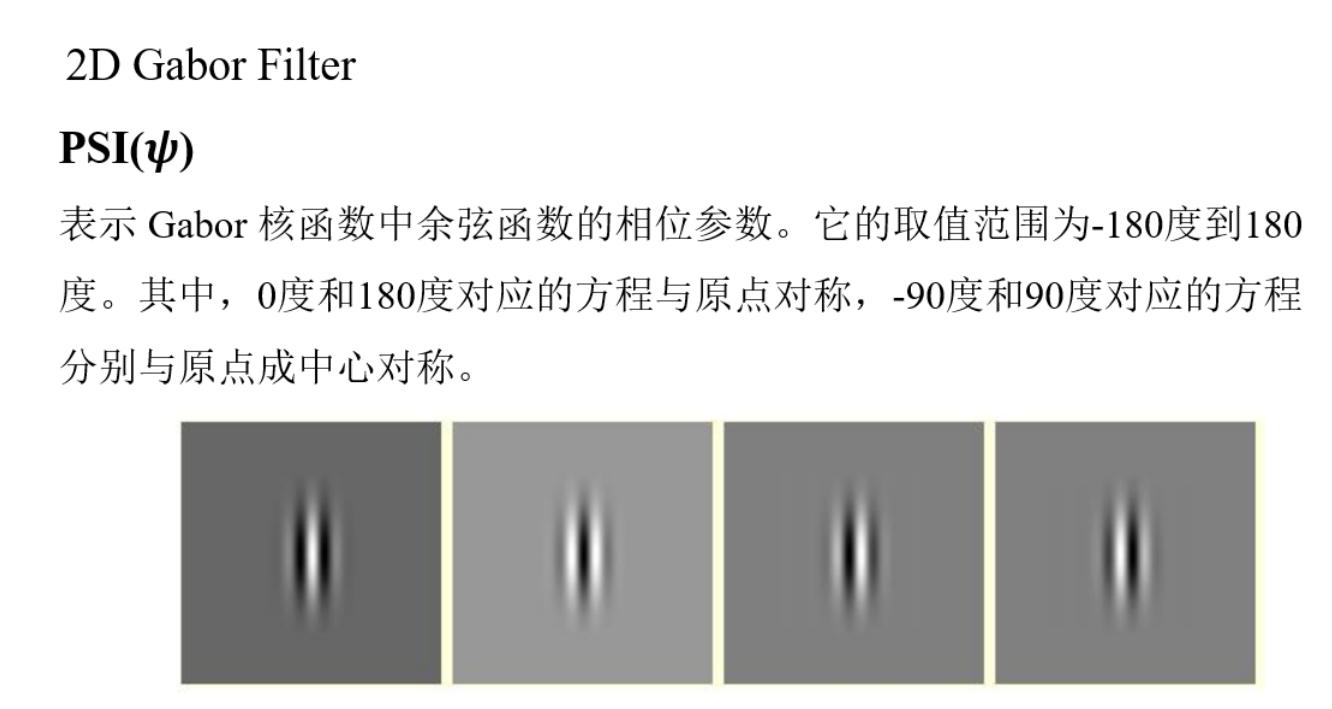

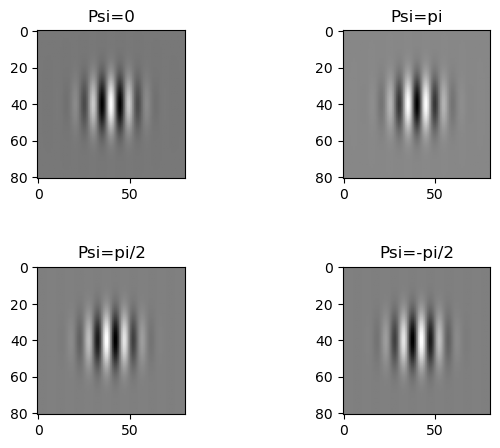

In [ ]:
# show the gabor filter-Psi
# 中心处于什么位置
gabor_img_Psi_0 = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=10, Psi=0, Gamma=1.)

gabor_img_Psi_180 = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=10, Psi=pi, Gamma=1.)

gabor_img_Psi_90 = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=10, Psi=pi/2, Gamma=1.)

gabor_img_Psi_90_ = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=10, Psi=-pi/2, Gamma=1.)


plt.subplot(221),plt.imshow(gabor_img_Psi_0, cmap="gray"),plt.title("Psi=0")

plt.subplot(222),plt.imshow(gabor_img_Psi_180, cmap="gray"),plt.title("Psi=pi")

plt.subplot(223),plt.imshow(gabor_img_Psi_90, cmap="gray"),plt.title("Psi=pi/2")

plt.subplot(224),plt.imshow(gabor_img_Psi_90_, cmap="gray"),plt.title("Psi=-pi/2")


plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.6)


plt.show()

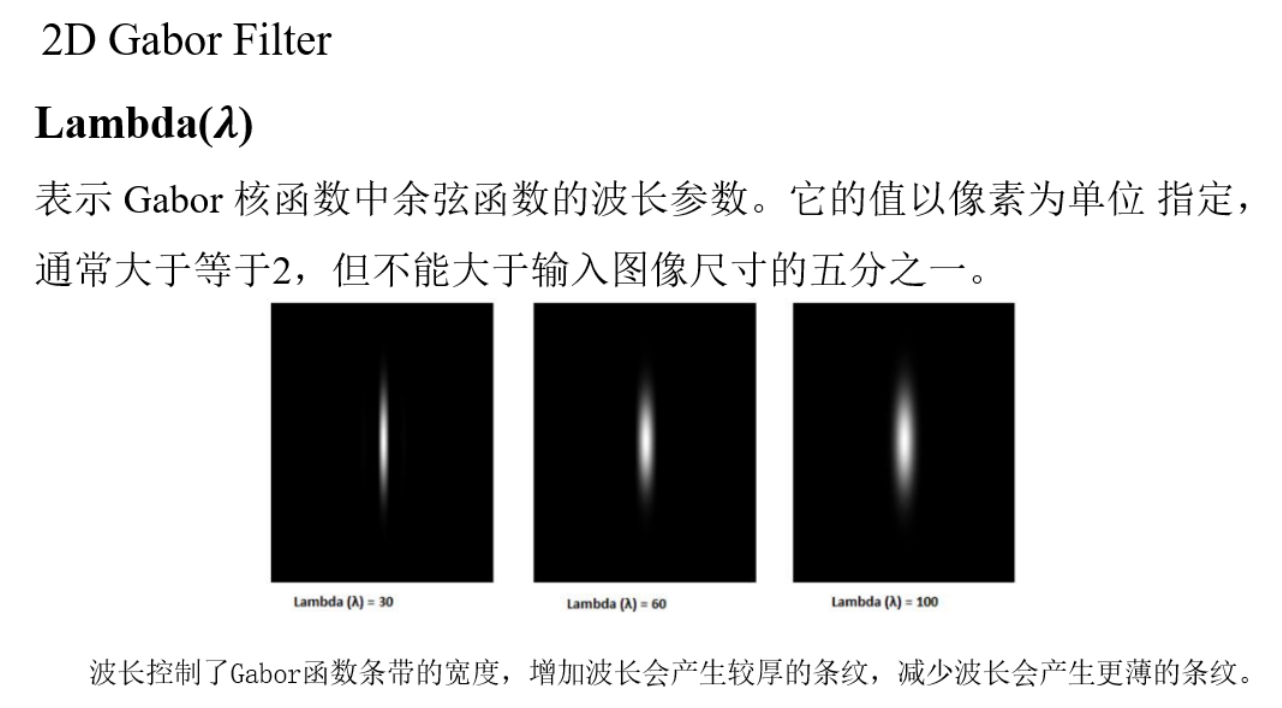

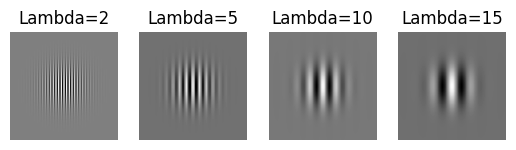

In [ ]:
# show the gabor filter-Lambba
# lambda太大，波长太长，波纹太少，特征不明显
gabor_img_pi0 = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=2, Psi=0, Gamma=1.)

gabor_img_pi = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=5, Psi=0, Gamma=1.)

gabor_img_pi2 = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=10, Psi=0, Gamma=1.)

gabor_img_pi22 = Gabor_filter(K_size=81, Sigma=10., Theta=0., Lambda=15, Psi=0, Gamma=1.)


plt.subplot(141),plt.imshow(gabor_img_pi0, cmap="gray"),plt.title("Lambda=2"),plt.axis('off')

plt.subplot(142),plt.imshow(gabor_img_pi, cmap="gray"),plt.title("Lambda=5"),plt.axis('off')

plt.subplot(143),plt.imshow(gabor_img_pi2, cmap="gray"),plt.title("Lambda=10"),plt.axis('off')

plt.subplot(144),plt.imshow(gabor_img_pi22, cmap="gray"),plt.title("Lambda=15"),plt.axis('off')

plt.show()

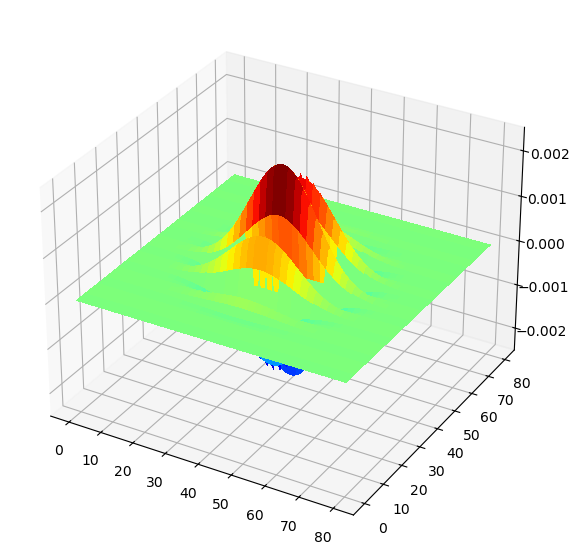

In [ ]:
# Draw spatial and frequency domain function diagram of a Gabor filter

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection='3d')
X = np.arange(gabor_img.shape[0])
Y = np.arange(gabor_img.shape[1])
X, Y = np.meshgrid(Y, X) # 这个meshgrid一般产生三维网格，由若干离散的片组成
ax.plot_surface(X, Y, gabor_img, cmap="jet", linewidth=1, antialiased=False)

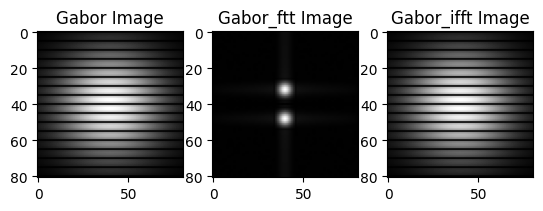

In [ ]:
def visualize(x, gamma=1):
    x = np.absolute(x)
    x - x.min()
    x = x/x.max()
    x = np.power(x, gamma)
    x *= 255
    return x.astype(np.uint8)

gabor_fft = fftshift(fft2(gabor_img, axes=(0,1)))

gabor_ifft = ifft2(ifftshift(gabor_fft))

plt.subplot(131),plt.imshow(visualize(gabor_img, 0.25), cmap="gray"),plt.title("Gabor Image")

plt.subplot(132),plt.imshow(visualize(gabor_fft, 0.25), cmap="gray"),plt.title("Gabor_ftt Image")

plt.subplot(133),plt.imshow(visualize(gabor_ifft, 0.25), cmap="gray"),plt.title("Gabor_ifft Image")

plt.show()



# Application

Magic Filter:
1. Create several different Gabor filter
2. Create accum matrix (same size of input image)
3. Filter the original image
4. Compare two original and filtered image by bit, copy higher value one to accum matrix
5. repeat step3 and step4

In [ ]:
def build_filters():
    filters = []
    ksize = 31
    # 16 filters with different theta
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

In [ ]:
def process_threaded(img, filters, threadn = 8):
    accum = np.zeros_like(img)
    def f(kern):
        return cv.filter2D(img, cv.CV_8UC3, kern)
    pool = ThreadPool(processes=threadn)
    for fimg in pool.imap_unordered(f, filters):
        np.maximum(accum, fimg, accum)
    return accum

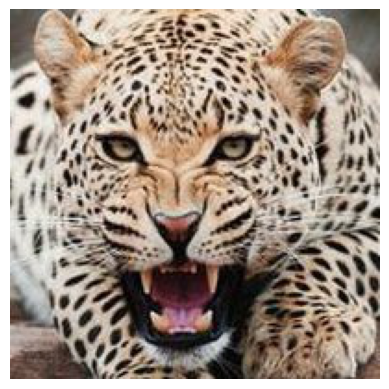

In [ ]:
img_fn = 'bao1.jpg'
img = cv.imread(img_fn)
img = img[:, :, ::-1]
plt.axis("off")
plt.imshow(img)

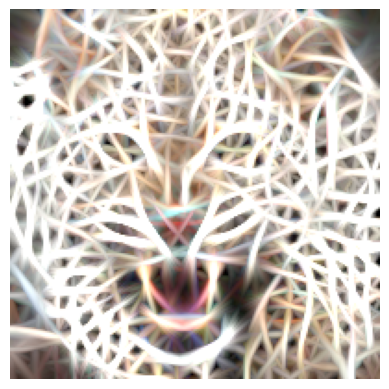

In [ ]:
filters = build_filters()
res2 = process_threaded(img, filters)
plt.axis("off")
plt.imshow(res2)